# DBC Single Data Optimization

## Initialization 

In [1246]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Data

Tourist Lake, 15 January 2013, Tuesday
Tourist Lake, 13 February 2013, Wednesday
Tourist Lake, 13 March 2013, Wednesday
Tourist Lake, 08 April 2013, Monday
Tourist Lake, 13 May 2013, Monday
Tourist Lake, 17 June 2013, Monday
Tourist Lake, 15 July 2013, Monday
Tourist Lake, 15 August 2013, Thursday
Tourist Lake, 17 September 2013, Wednesday
Tourist Lake, 14 October 2013, Monday
Tourist Lake, 13 November 2013, Wednesday
Tourist Lake, 09 December 2013, Monday
Tourist Lake, 13 January 2014, Monday
Tourist Lake, 13 February 2014, Thursday
Tourist Lake, 13 March 2014, Thursday
Tourist Lake, 14 April 2014, Monday
Tourist Lake, 15 May 2014, Thursday
Tourist Lake, 11 June 2014, Tuesday
Tourist Lake, 14 July 2014, Monday
Tourist Lake, 13 August 2014, Wednesday
Tourist Lake, 15 September 2014, Monday
Tourist Lake, 15 October 2014, Wednesday
Tourist Lake, 13 November 2014, Thursday
Tourist Lake, 15 December 2014, Monday
Tourist Lake, 13 January 2015, Tuesday
Tourist Lake, 16 February 2015, Monday


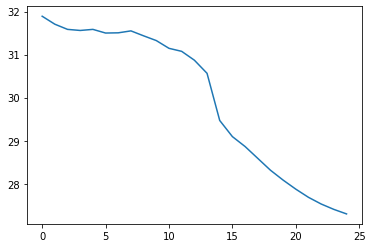

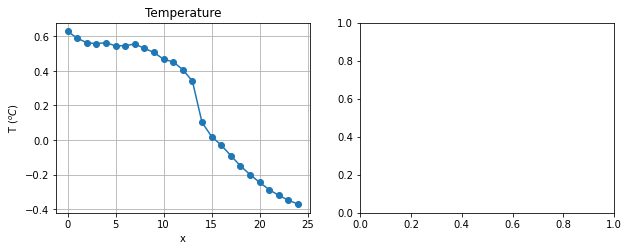

In [1247]:
import pandas as pd
# df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)
temp_df = pd.read_excel("./lake_data/aOTM summary 2013.xls", sheet_name='Temp')

from utils.general import data_normalization
# temperature = df[2].to_numpy()
# salinity = df[3].to_numpy()
idx_list = []
for i in range(38):
    idx = i*3 + 1
    date = temp_df.iloc[0,idx]
    print(date)
    idx_list.append(idx)
temp_profiles = temp_df.iloc[44:,idx_list]
temperature = temp_profiles.mean(axis=1).to_numpy()
temperature = temp_profiles.iloc[:,4].to_numpy() # 4 is flat
plt.plot(temperature)
plt.show()

nx = len(temperature) - 1
x = np.linspace(0, nx, nx +1)

temperature = data_normalization(temperature, 29.0, temperature.ptp())
# salinity = data_normalization(salinity, 33.5, df[3].to_numpy().ptp())

fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
ax[0]. plot(x,temperature,'o-')
ax[0].set_title('Temperature')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'T ($^o C$)')
ax[0].grid('on')

# ax[1].plot(x,salinity,'o-')
# ax[1].set_title('Salinity')
# ax[1].set_xlabel('x')
# ax[1].set_ylabel(r'S ($ppt$)')
# ax[1].grid('on')



## Initialization

In [1248]:
nx = nx
a,b = 0,1
bc_type = 'DBC'
omega = 1.0
oce_val = 0.0 if bc_type == 'DBC' else -0.2
if bc_type == 'DBC':
    gamma = 2e-4
elif bc_type == 'NBC':
    gamma = 1.25e-4
else:
    raise ValueError('Unknown bc type')

gamma = 1e-5

run = single_data_run(nx, a, b, bc_type, omega, oce_val, normalized_mean=oce_val)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

## Distribution forcing

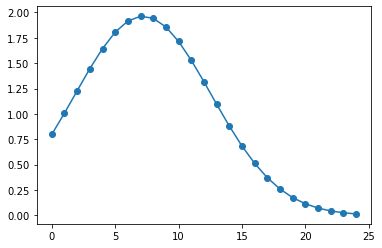

In [1249]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Boudnary Condition

In [1250]:
uL = temperature[0] if bc_type == 'DBC' else 1.0
uR = temperature[-1] if bc_type == 'DBC' else 0.0
print(f'uL: {uL}, uR: {uR}')
run.BC_setup(uL, uR)

uL: 0.6296296296296298, uR: -0.37037037037037024


## Forcing $g$

coef of solar: 0.03162927272727273


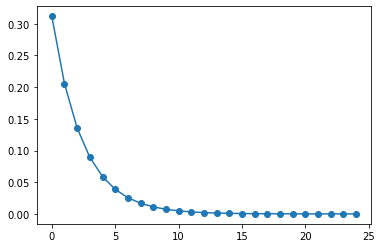

In [1251]:
from utils.general import normalize_function
c_1 = 20
peak_loc = 0.3 if bc_type == 'DBC' else 0.9
gauss_var = 1/30
# g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g_str = f'std::exp(-10*x[0])'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef = 1.73961e-6 /5.5e-5 
print('coef of solar:',coef)
g.vector().set_local(g_array[::-1]*coef)
run.extra_f_setup(g_sun = g)
plt.plot(x, run.g_sun.compute_vertex_values(), 'o-')

## Data Setup

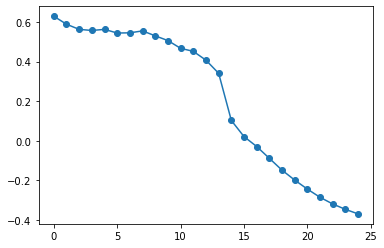

In [1252]:
ud_array = temperature if bc_type == 'DBC' else salinity
run.data_setup(ud_array=ud_array, normalize=False)
plt.plot(x, run.ud.compute_vertex_values(), 'o-')


## Initial Guess Setup

0.6296296296296298
-0.37037037037037024


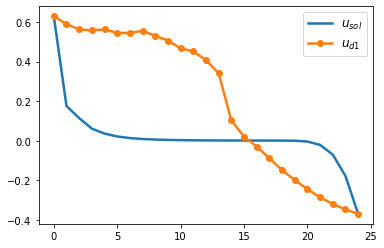

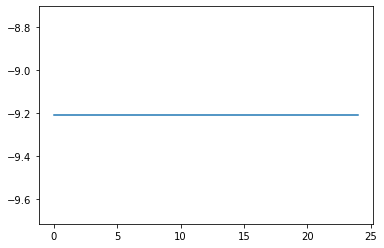

In [1253]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(pow(10,-4))", degree=1),run.Vm)
m0 = m.compute_vertex_values()
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    # print(y1[0], y1[-1])
elif bc_type == 'NBC':
    try:
        print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
        print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    except:
        print('sum wrong')
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

# plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

## Optimization Step

In [1254]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter, real_data = True)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg   GaussNewt    symm_diff
 1     1   6.54562e-02   1.29350e-01   1.56274e-03   1.00000e+00   4.46732e-02   4.60362e-03   1.00e+00   5.000e-01   True   0.00e+00
 2     1   6.47530e-02   1.25852e-01   3.65406e-03   9.90103e-01   3.22876e-02   4.55805e-03   1.00e+00   5.000e-01   True   4.34e-19
 3     1   6.45848e-02   1.24403e-01   4.76673e-03   4.01931e-01   1.95911e-02   1.85034e-03   1.00e+00   4.019e-01   True   6.51e-19
 4     2   6.45424e-02   1.23941e-01   5.14382e-03   4.51905e-01   1.57087e-02   2.08040e-03   1.00e+00   4.519e-01   True   2.17e-19
 5     2   6.45005e-02   1.23435e-01   5.56579e-03   3.82459e-01   1.94710e-02   1.76069e-03   1.00e+00   3.825e-01   True   4.34e-19
 6     2   6.43086e-02   1.22651e-01   5.96652e-03   7.41429e-01   1.89581e-02   3.41325e-03   1.00e+00   5.000e-01   False   8.67e-19
 7     0   6.33778e-02   1.18250e-01   8.50534e-03   

## Plot Results

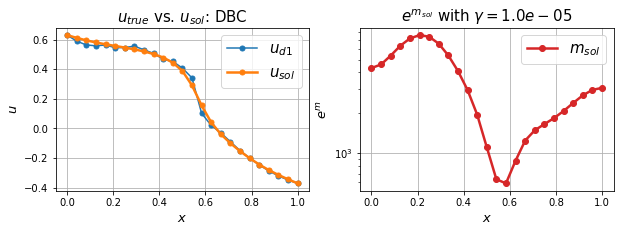

In [1255]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=5)
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d2}$', markersize=5)
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
# ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].semilogy(x,np.exp(m.compute_vertex_values()), '-o', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].plot(x,np.exp(m0))
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = False
save_plot = 1
if save_plot:
    if not eps:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.png',dpi=250)
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real.png',dpi=250)
    else:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.eps',format='eps',dpi=250,bbox_inches='tight')
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real2.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

In [1256]:
m_array = m.compute_vertex_values()

## Eigenvalues


In [763]:
k = run.nx
idx = nx  # number of eigenvalues saved for plotting 
lmbda, evecs = run.eigenvalue_request(m, p=20, k=idx)
if bc_type == 'DBC':
    DBC_eig = lmbda.copy()
elif bc_type == 'NBC':
    NBC_eig = lmbda.copy()
else:
    raise ValueError(f'Unknown BC type: {bc_type}')

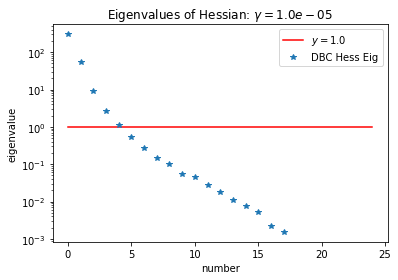

In [764]:
cutoff_num = 1.0
k = idx
plt.plot(range(0,k+1), np.ones(k+1)*cutoff_num, '-r',label=f'$y={cutoff_num}$')
if 'DBC_eig' in locals():
    plt.plot(range(0,k), (DBC_eig-1)[:k], '*', label='DBC Hess Eig')
if 'NBC_eig' in locals():
    plt.plot(range(0,k), (NBC_eig-1)[:k], '*', label='NBC Hess Eig')
if 'dual_eig' in locals():
    plt.plot(range(0,k), (dual_eig-1)[:k], 'b*', label='Double Data Eig')
# plt.ylim([0.5,1.5])
plt.legend()
plt.yscale('log')
plt.xlabel('number')
plt.ylabel('eigenvalue')
plt.title(f'Eigenvalues of Hessian: $\gamma = {gamma:1.1e}$')
# plt.savefig('./log/img/eigenvalues_singledata.eps', format='eps',dpi=250)
plt.show()

# NBC Single Data

## Initialization

In [26]:
from helm_eq import single_data_run

import dolfin as dl
import ufl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing Data

salinity ptp 2.8500000000000014


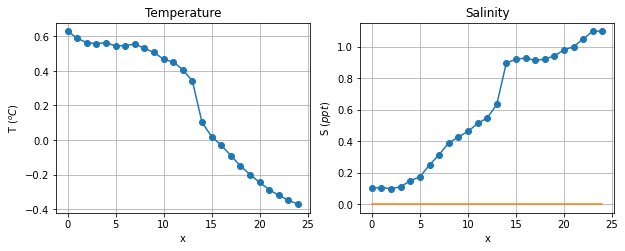

In [27]:
import pandas as pd
# df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)
temp_df = pd.read_excel("./lake_data/aOTM summary 2013.xls", sheet_name='Temp')
sal_df = pd.read_excel("./lake_data/aOTM summary 2013.xls", sheet_name='Sal')
df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)

from utils.general import data_normalization
# temperature = df[2].to_numpy()
# salinity = df[3].to_numpy()
idx_list = []
for i in range(38):
    idx = i*3 + 1
    date = temp_df.iloc[0,idx]
    # print(date)
    idx_list.append(idx)
temp_profiles = temp_df.iloc[44:,idx_list]
sal_profiles = sal_df.iloc[45:,idx_list]
temperature = temp_profiles.mean(axis=1).to_numpy()
temperature = temp_profiles.iloc[:,4].to_numpy()
salinity = sal_profiles.iloc[:,4].to_numpy()
print('salinity ptp',salinity.ptp())
# plt.plot(temperature)
# plt.show()
# u_sal = dl.Function(run.Vu)
# u_sal.vector().set_local(salinity[::-1])
# plt.plot(u_sal.compute_vertex_values())
# plt.show()
# rhs_test = dl.assemble(run.f * u_sal * dl.dx)
# print('itegral: ', rhs_test)


nx = len(temperature) - 1
x = np.linspace(0, nx, nx +1)

temperature = data_normalization(temperature, 29.0, temperature.ptp())
# salinity = data_normalization(df[3].to_numpy(), 30.84, df[3].to_numpy().ptp())
sal_ptp = salinity.ptp()
sal_oce = 30.8 -3
salinity = data_normalization(salinity, sal_oce, salinity.ptp())

fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
ax[0]. plot(x,temperature,'o-')
ax[0].set_title('Temperature')
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'T ($^o C$)')
ax[0].grid('on')

ax[1].plot(x,salinity,'o-')
ax[1].plot((0,24), (0,0))
ax[1].set_title('Salinity')
ax[1].set_xlabel('x')
ax[1].set_ylabel(r'S ($ppt$)')
ax[1].grid('on')


## Initializing runs

In [28]:
nx = nx
print(nx)
a,b = 0,1
bc_type = 'NBC'
# val_in = 1/ 2.8500000000000014
val_in = 0.0
omega = 1.0
# gamma =1.0e-12
x = np.linspace(0,1,nx+1)
# gamma = 1.0e-4

gamma = 1e-7

run = single_data_run(nx, a, b, bc_type, omega, val_in, normalized_mean=0.0) # remember to change the value of normalizations (check)
run.misfit_reg_setup(gamma)

if bc_type == 'DBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
elif bc_type == 'NBC':
    a_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val * self.u_trial * self.u_test * ufl.dx'
    L_state_str = 'self.f * self.omega_val * self.u_oce_val * self.u_test * ufl.dx + self.g_sun * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
    a_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val * self.p_trial * self.p_test * ufl.dx'
    L_adj_str = '-ufl.inner(u - self.ud, self.p_test) * ufl.dx'
run.state_adj_str_setup(a_state_str, L_state_str, a_adj_str, L_adj_str)

24


## Setup Distribution

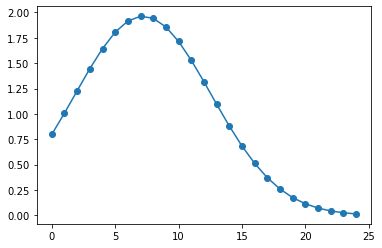

In [29]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/10
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
# f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1} + exp(-pow(x[0] - 0.9, 2) / 0.01) * 5'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')

## Setup $g$

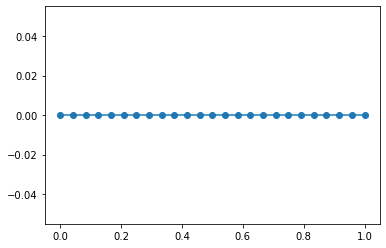

In [30]:

from utils.general import normalize_function
c_1 = 10
peak_loc = 0.2 if bc_type == 'DBC' else 0.9
gauss_var = 1/10
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef = 0.25 if bc_type == 'DBC' else 0.0
g.vector().set_local(g_array[::-1]*coef)
run.extra_f_setup(g_sun = g)
plt.plot(x, g.compute_vertex_values(), 'o-')


## Data Setup

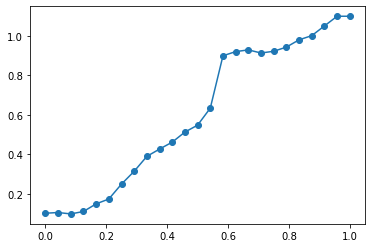

In [31]:
ud_array = temperature if bc_type == 'DBC' else salinity
run.data_setup(ud_array=ud_array, normalize=False)
plt.plot(x, run.ud.compute_vertex_values(), 'o-')

### Compatibility condition 

In [32]:
dl.assemble(f* (run.u_oce - run.ud) * ufl.dx)

-0.39708102158685404

## Setup BC

In [33]:
rhs_value = dl.assemble(run.f*run.omega*(run.u_oce - run.ud) * ufl.dx)
print('integral', rhs_value)
rain_flux = 1e-7/5.5e-5/24/sal_ptp
uR = 0.1 #uL - rhs_value
uL = uR + rhs_value #- 1.0# -rain_flux
uL = rain_flux
uR = uL - rhs_value
# uR = 0.0
print('uL', uL, 'uR', uR)
# uL, uR = 1.0, 0.08
run.BC_setup(uL, uR)

integral -0.39708102158685404
uL 2.6581605528973932e-05 uR 0.39710760319238303


## Initial Guess

sum wrong
2.6581605528973932e-05 0.39710760319238303


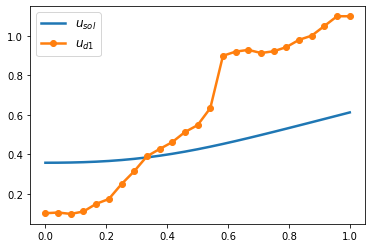

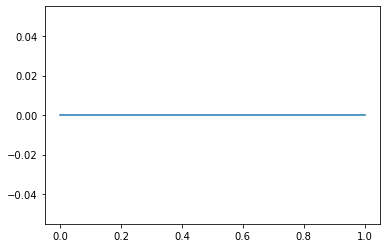

In [34]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(1)", degree=1),run.Vm)
m0 = m.compute_vertex_values()
# m.assign(mtrue)
# m = mtrue

u,_,_ = run.fwd_solve(m)
if bc_type == 'DBC':
    print(u.compute_vertex_values()[0])
    print(u.compute_vertex_values()[-1])
    # print(y1[0], y1[-1])
elif bc_type == 'NBC':
    try:
        print((u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() * np.exp(mtrue_array[0]))
        print((u.compute_vertex_values()[-1] - u.compute_vertex_values()[-2])/run.mesh.hmax() * np.exp(mtrue_array[-1]))
    except:
        print('sum wrong')
    print(uL, uR)

plt.plot(x,u.compute_vertex_values(), label=r'$u_{sol}$',linewidth=2.5)
plt.plot(x,run.ud.compute_vertex_values(),'o-', label=r'$u_{d1}$',linewidth=2.5)
plt.legend(prop={'size':12})
plt.show()

# plt.plot(x,mtrue_array, 'o')
plt.plot(x, m.compute_vertex_values())

## Optimization

In [35]:
tol = 1e-9
c = 1e-4
maxiter=100
m, u = run.opt_loop(m, tol, c, maxiter, real_data = True)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg   GaussNewt    symm_diff
 1     1   8.29801e-03   1.65939e-02   2.06571e-06   1.00000e+00   3.02806e-01   3.31318e-02   5.00e-01   5.000e-01   True   2.22e-16
 2     1   5.62590e-03   1.12501e-02   1.66230e-06   1.35118e+00   7.38895e-02   4.47669e-02   1.00e+00   5.000e-01   True   0.00e+00
 3     2   3.14799e-03   6.29196e-03   4.02917e-06   4.00382e-01   9.00391e-02   1.32654e-02   1.00e+00   4.004e-01   True   0.00e+00
 4     1   1.57125e-03   3.13887e-03   3.63646e-06   8.25310e-01   5.63319e-02   2.73440e-02   1.00e+00   5.000e-01   True   2.22e-16
 5     6   6.41474e-04   1.27080e-03   1.21487e-05   9.79920e-02   5.30062e-02   3.24665e-03   5.00e-01   9.799e-02   True   0.00e+00
 6     1   3.78170e-04   7.44355e-04   1.19844e-05   3.09649e-01   2.25182e-02   1.02592e-02   1.00e+00   3.096e-01   False   0.00e+00
 7    12   3.57350e-04   6.80059e-04   3.46416e-05   

## Plotting Results

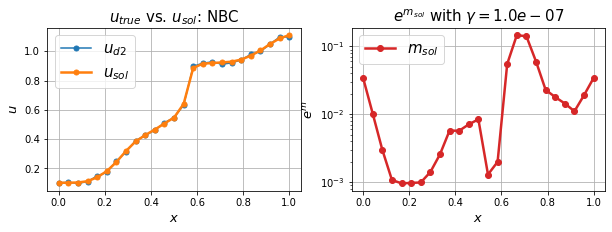

In [36]:
x = np.linspace(0,1,nx+1)
f = run.f

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,3),sharey=False)
# fig.tight_layout(v_pad=2)
# plt.subplots_adjust(top=0.85)

# ax[0].plot(x, f.compute_vertex_values(run.mesh), 'seagreen', label=r'$f=Gaussian$', linewidth=2)
# ax[0].grid('on')
# ax[0].set_xlabel(r'$x$', fontsize=13)
# ax[0].set_ylabel(r'$f$', fontsize=13)
# ax[0].set_title(r'Forcing Term $d_{in}$, $\bar{\omega} = '+f'{run.omega:1.1e}$', fontsize=15)
# # ax[0].legend()
# ax[0].legend(prop={'size':12})

if bc_type == 'DBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d1}$', markersize=5)
elif bc_type == 'NBC':
    ax[0].plot(x, run.ud.compute_vertex_values() , 'o-',label=r'$u_{d2}$', markersize=5)
else:
    raise ValueError(f'Unknown BC type: {bc_type}')
# ax[1].plot(x, run.ud.compute_vertex_values()-0.02 , 'o-',label=r'$u_{d2}$', markersize=3)
ax[0].plot(x, u.compute_vertex_values(), 'o-', markersize=5, label=r'$u_{sol}$',linewidth=2.5)
ax[0].grid('on')
ax[0].set_xlabel(r'$x$', fontsize=13)
ax[0].set_ylabel(r'$u$', fontsize=13)
ax[0].set_title(r'$u_{true}$ vs. $u_{sol}$: '+ f'{bc_type}', fontsize=15)
ax[0].legend(prop={'size':15})

text = ax[1].yaxis.get_offset_text()
text.set_fontsize(8)
# ax[2].plot(x, np.exp(m.compute_vertex_values()), 'cornflowerblue', label=r'$exp(m_{sol}$)',linewidth=2.5)
# ax[2].plot(x, np.exp(m_true.compute_vertex_values()), '--', c='coral', label=r'$exp(m_{true}$)',linewidth=2.5)
# ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].semilogy(x,np.exp(m.compute_vertex_values())*(nx+1)**2 * 5.5e-5, '-o', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].plot(x,np.exp(m0))
ax[1].grid('on')
ax[1].set_xlabel(r'$x$', fontsize=13)
ax[1].set_ylabel(r'$e^m$', fontsize=13)
ax[1].set_title(r'$e^{m_{sol}}$ with '+f'$\gamma = {gamma:1.1e}$', fontsize=15)
ax[1].legend(prop={'size':15})

# plt.savefig(f'./log/img/helm_DB_synth.eps', format='eps',dpi=250)
eps = False
save_plot = 1
if save_plot:
    if not eps:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.png',dpi=250)
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real.png',dpi=250)
    else:
        if bc_type == 'DBC':
            plt.savefig(f'./log/img/helm_DB_real.eps',format='eps',dpi=250,bbox_inches='tight')
        elif bc_type == 'NBC':
            plt.savefig(f'./log/img/helm_NB_real2.eps',format='eps',dpi=250,bbox_inches='tight')
plt.show()

In [13]:
m_array = m.compute_vertex_values()

In [14]:
print(dl.assemble(run.f* (run.u_oce - run.ud) * ufl.dx))
em0 = np.exp(m.compute_vertex_values())[0]#*(nx+1)**2 * 5.5e-5
emR = np.exp(m.compute_vertex_values())[13]#*(nx+1)**2 * 5.5e-5
duL = (u.compute_vertex_values()[1] - u.compute_vertex_values()[0])/run.mesh.hmax() 
duR = (u.compute_vertex_values()[13] - u.compute_vertex_values()[12])/run.mesh.hmax()
print(em0, emR, duL, duR)
lbc = em0*duL
rbc = emR*duR
print('The lbc - rbc:', lbc - rbc)

-0.39708102158685404
0.9999871701692475 0.03745152427005557 0.00325190446503964 2.2430118645590427
The lbc - rbc: -0.08075235053989985


-0.12229312033081113


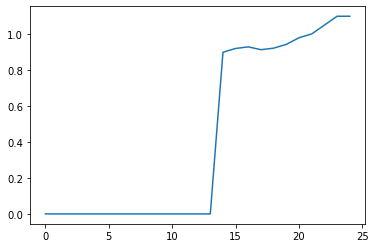

In [15]:
u_test = dl.Function(run.Vu)
ud_test_array = run.ud.compute_vertex_values()
ud_test_array[:14]  = 0
u_test.vector().set_local(ud_test_array[::-1])
plt.plot(u_test.compute_vertex_values())
print(dl.assemble(run.f* (run.u_oce - u_test) * ufl.dx))

# Dual Data Optimization

In [3]:
from helm_eq import dual_data_run
import dolfin as dl
import ufl

import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Data Importing

Tourist Lake, 15 January 2013, Tuesday
Tourist Lake, 13 February 2013, Wednesday
Tourist Lake, 13 March 2013, Wednesday
Tourist Lake, 08 April 2013, Monday
Tourist Lake, 13 May 2013, Monday
Tourist Lake, 17 June 2013, Monday
Tourist Lake, 15 July 2013, Monday
Tourist Lake, 15 August 2013, Thursday
Tourist Lake, 17 September 2013, Wednesday
Tourist Lake, 14 October 2013, Monday
Tourist Lake, 13 November 2013, Wednesday
Tourist Lake, 09 December 2013, Monday
Tourist Lake, 13 January 2014, Monday
Tourist Lake, 13 February 2014, Thursday
Tourist Lake, 13 March 2014, Thursday
Tourist Lake, 14 April 2014, Monday
Tourist Lake, 15 May 2014, Thursday
Tourist Lake, 11 June 2014, Tuesday
Tourist Lake, 14 July 2014, Monday
Tourist Lake, 13 August 2014, Wednesday
Tourist Lake, 15 September 2014, Monday
Tourist Lake, 15 October 2014, Wednesday
Tourist Lake, 13 November 2014, Thursday
Tourist Lake, 15 December 2014, Monday
Tourist Lake, 13 January 2015, Tuesday
Tourist Lake, 16 February 2015, Monday


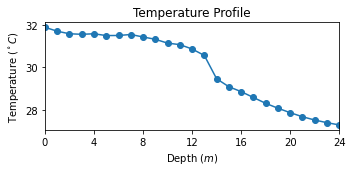

In [4]:
import pandas as pd
df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)
df2 = pd.read_excel('./lake_data/aOTM summary 2013.xls', header=None, sheet_name='Temp')
temp_df = pd.read_excel("./lake_data/aOTM summary 2013.xls", sheet_name='Temp')
sal_df = pd.read_excel("./lake_data/aOTM summary 2013.xls", sheet_name='Sal')
df = pd.read_excel('./lake_data/2008_10_14_initialData.xls', header=None)

from utils.general import data_normalization
# temperature = df[2].to_numpy()
# salinity = df[3].to_numpy()
idx_list = []
for i in range(38):
    idx = i*3 + 1
    date = temp_df.iloc[0,idx]
    print(date)
    idx_list.append(idx)
temp_profiles = temp_df.iloc[44:,idx_list]
sal_profiles = sal_df.iloc[45:,idx_list]
temperature = temp_profiles.mean(axis=1).to_numpy()
temperature = temp_profiles.iloc[:,4].to_numpy()
salinity = sal_profiles.iloc[:,4].to_numpy()
fig, ax = plt.subplots(ncols=1, figsize=(5, 2.5))
x = np.arange(len(temperature))
ax. plot(x,temperature,'o-')
ax.set_title('Temperature Profile')
ax.set_xlabel(r'Depth ($m$)')
ax.set_ylabel(r'Temperature ($^\circ C$)')
ax.set_xlim([0,24])
ax.set_xticks([0,4,8,12,16,20,24])

# ax[1].plot(x,salinity,'o-')
# ax[1].set_title('Salinity Profile')
# ax[1].set_xlabel(r'Depth ($m$)')
# ax[1].set_ylabel(r'Salinity ($ppt$ or $kg/m^3$)')
# ax[1].set_xlim([0,24])
# ax[1].set_xticks([0,4,8,12,16,20,24])
plt.tight_layout()
# plt.savefig('./log/img/lakedata.eps', format='eps',dpi=250)
# plt.plot(temperature)
# plt.show()

nx = len(temperature) - 1
x = np.linspace(0, nx, nx +1)

u_oce_temp = 29.0
temperature = data_normalization(temperature, u_oce_temp, temperature.ptp())
# salinity = data_normalization(df[3].to_numpy(), 33.5, df[3].to_numpy().ptp())
u_oce_sal = 27.8
sal_ptp = salinity.ptp()
salinity = data_normalization(salinity, u_oce_sal, salinity.ptp())

# fig, ax = plt.subplots(ncols=2, figsize=(10, 3.5))
# ax[0]. plot(np.linspace(0,1,nx+1),temperature,'o-')
# ax[0].set_title('Temperature')
# ax[0].set_xlabel('x')
# ax[0].set_ylabel('Temperature')

# ax[1].plot(np.linspace(0,1,nx+1),salinity,'o-')
# ax[1].plot((0,1),(0,0))
# ax[1].set_title('Salinity')
# ax[1].set_xlabel('x')
# ax[1].set_ylabel('Salinity')

# plt.savefig('./log/img/lakedata.eps', format='eps',dpi=250)

## Initialization

In [5]:
nx = nx
a,b = 0,1
omega = 1.0
oce_val1 = 0.0
oce_val2 = 0.0
gamma1 = 4.0e-5 #1.048e-4
gamma2 = 4.0e-5 #1.6e-3
print(f'gamma1   = {gamma1}, gamma2 = {gamma2}')
run = dual_data_run(nx,a,b,gamma1, gamma2, omega,omega,oce_val1,oce_val2, normalized_mean1=0.0, normalized_mean2=0.0)

beta1 = 0.5
beta2 = 0.5
run.misfit_reg_setup(beta1, beta2)

a1_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val1 * self.u_trial * self.u_test * ufl.dx'
L1_state_str = 'self.f * self.omega_val1 * self.u_oce_val1 * self.u_test * ufl.dx + self.g1 * self.u_test * ufl.dx'
a1_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val1 * self.p_trial * self.p_test * ufl.dx'
L1_adj_str = '-ufl.inner(u1 - self.ud1, self.p_test) * ufl.dx'

a2_state_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.u_trial), ufl.grad(self.u_test)) * ufl.dx + self.f * self.omega_val2 * self.u_trial * self.u_test * ufl.dx'
L2_state_str = 'self.f * self.omega_val2 * self.u_oce_val2 * self.u_test * ufl.dx + self.g2 * self.u_test * ufl.dx  + self.j1 * self.u_test * self.ds(1) - self.j0 * self.u_test * self.ds(0)'
a2_adj_str = 'ufl.inner(ufl.exp(m) * ufl.grad(self.p_trial), ufl.grad(self.p_test)) * ufl.dx + self.f * self.omega_val2 * self.p_trial * self.p_test * ufl.dx'
L2_adj_str = '-ufl.inner(u2 - self.ud2, self.p_test) * ufl.dx'

run.state_adj_str_setup(a1_state_str, L1_state_str, a1_adj_str, L1_adj_str, a2_state_str, L2_state_str, a2_adj_str, L2_adj_str)

gamma1   = 4e-05, gamma2 = 4e-05


## Distribution Setup

Text(0.5, 1.0, 'Distribution $g_T$ and $g_S$')

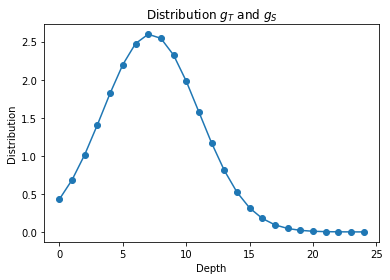

In [6]:
from utils.general import normalize_function
c_1 = 10
peak_loc = 0.3
gauss_var = 1/20
f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
# f_str = '1'
# f_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1} - exp(-pow(x[0] - 0.3, 2) / 0.01) * 5'
f = normalize_function(f_str, run.Vm, ufl.dx)
forcing_array = f.compute_vertex_values()
run.f_setup(f.compute_vertex_values())
plt.plot(run.f.compute_vertex_values(), 'o-')
plt.xlabel('Depth')
plt.ylabel('Distribution')
plt.title(r'Distribution $g_T$ and $g_S$')
# plt.savefig('./log/img/distribution.eps', bbox_inches='tight', dpi=300, format='eps')

## Extra Forcing $g$

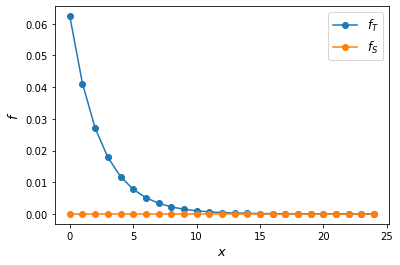

In [7]:
from utils.general import normalize_function
# ==================== Temperature ====================
c_1 = 10
peak_loc = 0.2
gauss_var = 1/10
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g_str = f'std::exp(-10*x[0])'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef_temperature = 1.73961e-6 /5.5e-5 /5 # the 5 is Delta Temperature
g1 = dl.Function(run.Vu)
g1.vector().set_local(g_array[::-1]*coef_temperature)

# ==================== Salinity ====================
c_1 = 10
peak_loc = 1.0
gauss_var = 1/2
g_str =  f'std::exp(-pow(x[0] - {peak_loc}, 2) / {gauss_var}) * {c_1}'
g = normalize_function(g_str, run.Vm, ufl.dx)
g_array = g.compute_vertex_values()

coef_salinity = 0.0
g2 = dl.Function(run.Vu)
g2.vector().set_local(g_array[::-1]*coef_salinity)
run.extra_f_setup(g1 = g1, g2 = g2)

plt.plot(x,run.g1.compute_vertex_values(),'o-',label=r'$f_T$')
plt.plot(x,run.g2.compute_vertex_values(),'o-',label=r'$f_S$')
plt.legend(prop={'size':12})
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$f$', fontsize=13)
# plt.savefig('./log/img/double_data_setupt_forcing.eps', bbox_inches='tight',format='eps')
plt.show()

## Data Setup

0.6007017543859644


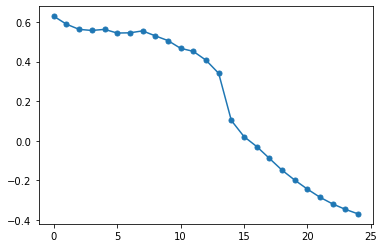

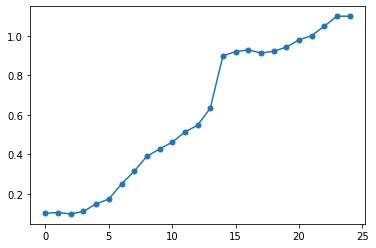

In [8]:
run.data_setup(temperature, salinity, normalize=False)

print(np.mean(run.ud2.compute_vertex_values()))
plt.plot(x,run.ud1.compute_vertex_values(), 'o-',markersize=5)
plt.show()
# plt.plot(y2, '-',markersize=5)
plt.plot(run.ud2.compute_vertex_values(), 'o-',markersize=5)
plt.show()

## Boundary condition setup

In [22]:
from numpy import cos, pi, sin, exp
rhs_value = dl.assemble(run.f*run.omega2*(run.u_oce2 - run.ud2) * ufl.dx)
print(f'rhs_value = {rhs_value}')
u1L_D = temperature[0]
u1R_D = temperature[-1]
rain_flux = 1e-7/5.5e-5/24/sal_ptp # nondimensional with 5.5e-5 = omega, 24 = L, and sal_ptp is the salinity peak to peak range
u2L_N = rain_flux
u2R_N = u2L_N - rhs_value
# u2R_N = 0
print(f'Dirichlet_L: {u1L_D}, Dirichlet_R: {u1R_D},')
print(f'NBC_L: {u2L_N}, NBC_R: {u2R_N}')
run.BC_setup(u1L_D, u1R_D, u2L_N, u2R_N)

rhs_value = -0.3495232097275094
Dirichlet_L: 0.6296296296296298, Dirichlet_R: -0.37037037037037024,
NBC_L: 2.6581605528973932e-05, NBC_R: 0.3495497913330384


## Initial Guess 

Text(0, 0.5, '$u_2$')

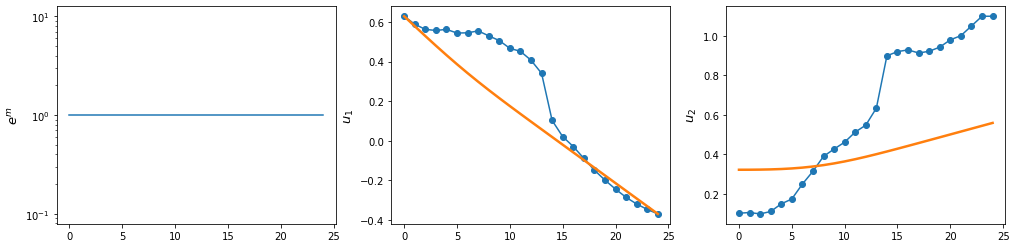

In [23]:
#initial guess m
m = dl.interpolate(dl.Expression("std::log(1)", degree=1),run.Vm)
# m.vector().set_local(m_array[::-1])
# m.assign(m)
u1,u2,_,_,_,_ = run.fwd_solve(m)
# print(u1.compute_vertex_values()[0])
# print(u1.compute_vertex_values()[-1])
# print((u2.compute_vertex_values()[1] - u2.compute_vertex_values()[0])/run.mesh.hmax())
# print((u2.compute_vertex_values()[-1] - u2.compute_vertex_values()[-2])/run.mesh.hmax())
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(17,4),sharey=False)
ax[0].semilogy(x, np.exp(m.compute_vertex_values()))
ax[0].set_ylabel('$e^m$', fontsize=13)

ax[1].plot(x, run.ud1.compute_vertex_values(), '-o')
ax[1].plot(x, u1.compute_vertex_values(), linewidth=2.5)
ax[1].set_ylabel('$u_1$', fontsize=13)

ax[2].plot(x, run.ud2.compute_vertex_values(), '-o')
ax[2].plot(x, u2.compute_vertex_values(),linewidth=2.5)
ax[2].set_ylabel('$u_2$', fontsize=13)

## Optimization Loop

In [24]:
tol = 1e-9
c = 1e-4
maxiter=100
run.mtrue=m
run.noise_level = None
m, u1, u2 = run.opt_loop(m, tol, c, maxiter, save_opt_log=False, plot_opt_step=False, plot_eigval=False)

Nit   CGit   cost          misfit        reg         rel_gradnorm    (G*D)/(l)       ||grad||       alpha      tolcg      GaussNewt      min|yTHx - xTHy|
 1     1   6.74367e-03   1.28012e-02   6.86144e-04   1.00000e+00   2.43507e-01   3.25901e-02   5.00e-01   True   5.000e-01   0.000e+00
 2     3   5.16819e-03   8.52881e-03   1.80757e-03   2.78193e-01   5.99115e-02   9.06635e-03   1.00e+00   True   2.782e-01   0.000e+00
 3     1   5.09712e-03   8.41852e-03   1.77572e-03   1.68386e-01   1.18377e-02   5.48770e-03   1.00e+00   True   1.684e-01   0.000e+00
 4     5   4.98391e-03   8.00684e-03   1.96097e-03   6.35837e-02   1.47168e-02   2.07220e-03   1.00e+00   True   6.358e-02   0.000e+00
 5     5   4.98189e-03   7.98352e-03   1.98026e-03   1.97997e-02   2.03471e-03   6.45274e-04   1.00e+00   True   1.980e-02   0.000e+00
 6     9   4.98187e-03   7.98389e-03   1.97984e-03   1.21046e-03   2.06456e-04   3.94490e-05   1.00e+00   False   1.210e-03   0.000e+00
Newton's method converged in  7   i

## Result Plotting

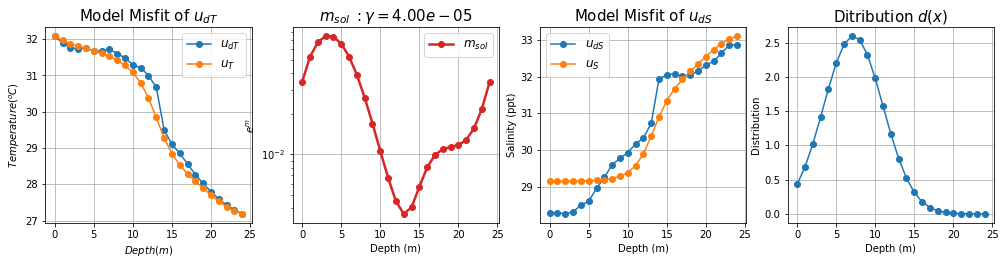

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17, 3.6)) 
std = df[2].to_numpy().ptp()
ax[0].plot(run.ud1.compute_vertex_values() * std + u_oce_temp, 'o-', label=r'$u_{dT}$')
ax[0].plot(u1.compute_vertex_values() * std + u_oce_temp, 'o-', label=r'$u_{T}$')
ax[0].set_xlabel(r'$Depth (m)$')
ax[0].set_ylabel(r'$Temperature (^oC)$')
ax[0].set_title(r'Model Misfit of $u_{dT}$', fontsize=15)
ax[0].grid()
ax[0].legend(fontsize=12)

# mse = (np.square(m_true.compute_vertex_values() - m.compute_vertex_values())).mean()
# ax[1].plot(x,np.exp(m_true.compute_vertex_values()), '-', label=r'$m_{true}$', linewidth=2.5,color = 'tab:blue')
ax[1].semilogy(np.exp(m.compute_vertex_values()) *(nx+1)**2 * 5.5e-5, '-o', label=r'$m_{sol}$', linewidth=2.5,color = 'tab:red')
# ax[1].set_title(f'gamma = {gamma[kappa_min_ind]:.3e}')
ax[1].set_xlabel(r'Depth (m)')
ax[1].set_ylabel(r'$e^m$')
ax[1].set_title(r'$m_{sol}$ '+f'$: \gamma = {run.gamma:1.2e}$', fontsize=15)
ax[1].grid()
ax[1].legend(fontsize=12)

std = df[3].to_numpy().ptp()
ax[2].plot(run.ud2.compute_vertex_values() * std + u_oce_sal, 'o-', label=r'$u_{dS}$')
ax[2].plot(u2.compute_vertex_values() * std + u_oce_sal, 'o-', label=r'$u_{S}$')
ax[2].set_xlabel(r'Depth (m)')
ax[2].set_ylabel(r'Salinity (ppt)')
ax[2].set_title(r'Model Misfit of $u_{dS}$', fontsize=15)
ax[2].grid()
ax[2].legend(fontsize=12)

ax[3].plot(run.f.compute_vertex_values(), 'o-', label=r'$f$')
ax[3].set_xlabel(r'Depth (m)')
ax[3].set_ylabel(r'Distribution')
ax[3].set_title(r'Ditribution $d(x)$', fontsize=15)
ax[3].grid()

# plt.savefig('./log/img/double_data_real_result.eps', bbox_inches='tight',format='eps')

# print(np.linalg.norm(np.exp(m_true.compute_vertex_values()) - np.exp(m.compute_vertex_values())))